# **References**


- https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-the-fundamentals-dfee054f978e
- https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Recommender%20Systems%20-%20The%20Fundamentals.ipynb

- https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847

# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os, sys
import re
import seaborn as sns

# Google colab setup

**Note:** Comment if run locally

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# cd '/content/gdrive/MyDrive/CMPE_256-Prg_Ass1_014749488'

/content/gdrive/MyDrive/256-indiv


# Books data

In [ ]:
books = pd.read_csv('processed_data/books_with_review.csv')
books = books.drop(['Unnamed: 0'], axis=1)
books.head(1)

,book_id,title,review_text,ratings_count,is_ebook,average_rating,publication_year,url,description,image_url,isbn
0,287141,The Aeneid for Boys and Girls,kid love book ancient history,46,False,4.13,2006.0,https://www.goodreads.com/book/show/287141.The...,"Relates in vigorous prose the tale of Aeneas, ...",https://s.gr-assets.com/assets/nophoto/book/11...,1599150603


# Ratings data

In [ ]:
ratings = pd.read_csv('input/train.csv','\t')
ratings.shape

(700000, 3)

In [ ]:
ratings.head()

,user_id,book_id,rating
0,12726,7784,5
1,23770,104293,4
2,15669,29291,4
3,649,420180,0
4,10980,7089179,0


In [ ]:
ratings['user_id'].nunique()

35280

In [ ]:
ratings['book_id'].nunique()

68371

In [ ]:
n_users = ratings['user_id'].nunique()
n_books = ratings['book_id'].nunique()
print(n_users*n_books)

2412128880


In [ ]:
ratings_new = ratings[ratings.book_id.isin(books.book_id)]

In [ ]:
print(ratings.shape)
print(ratings_new.shape)

(700000, 3)
(700000, 3)


## Dataset Sparsity

In [ ]:
sparsity = 1.0 - len(ratings_new)/float(n_users*n_books)
print('Sparsity level of Goodreads children dataset is ' +
     str(sparsity*100) + '%')

Sparsity level of Goodreads children dataset is 99.97097999174903%


In [ ]:
ratings_new.rating.value_counts()

0    239522
5    169680
4    160393
3    105120
2     20837
1      4448
Name: rating, dtype: int64

In [ ]:
ratings_new = ratings_new.fillna(0)
print(ratings_new.shape)

(700000, 3)


In [ ]:
ratings_new.tail()

,user_id,book_id,rating
699995,723,370493,0
699996,18071,5,0
699997,37159,423156,5
699998,31306,34002075,4
699999,10304,16102965,0


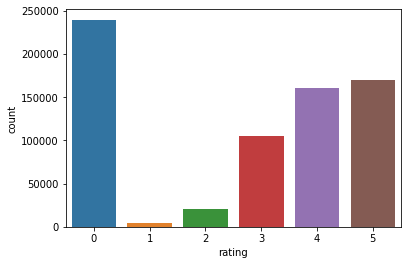

In [ ]:
sns.countplot(data = ratings_new, x = "rating")
plt.show()

# Top-5 Popularity based recommendations

In [ ]:
ratings_count = pd.DataFrame(ratings_new.groupby(['book_id'])['rating'].sum())
top5 = ratings_count.sort_values('rating', ascending = False).head(5)
print("Book recommendation by Popularity:")
top5.merge(books, left_index = True, right_on = 'book_id')


Book recommendation by Popularity:


,rating,book_id,title,review_text,ratings_count,is_ebook,average_rating,publication_year,url,description,image_url,isbn
311332,44454,5,Harry Potter and the Prisoner of Azkaban (Harr...,one definitely wasnt good second one much happ...,1876252,False,4.53,2004.0,https://www.goodreads.com/book/show/5.Harry_Po...,Harry Potter's third year at Hogwarts is full ...,https://images.gr-assets.com/books/1499277281m...,043965548X
311333,44454,5,Harry Potter and the Prisoner of Azkaban (Harr...,sirius,1876252,False,4.53,2004.0,https://www.goodreads.com/book/show/5.Harry_Po...,Harry Potter's third year at Hogwarts is full ...,https://images.gr-assets.com/books/1499277281m...,043965548X
311334,44454,5,Harry Potter and the Prisoner of Azkaban (Harr...,rowling harry gang though rather tire noble he...,1876252,False,4.53,2004.0,https://www.goodreads.com/book/show/5.Harry_Po...,Harry Potter's third year at Hogwarts is full ...,https://images.gr-assets.com/books/1499277281m...,043965548X
311335,44454,5,Harry Potter and the Prisoner of Azkaban (Harr...,really like one,1876252,False,4.53,2004.0,https://www.goodreads.com/book/show/5.Harry_Po...,Harry Potter's third year at Hogwarts is full ...,https://images.gr-assets.com/books/1499277281m...,043965548X
311336,44454,5,Harry Potter and the Prisoner of Azkaban (Harr...,get nothin one manage get hours either get bet...,1876252,False,4.53,2004.0,https://www.goodreads.com/book/show/5.Harry_Po...,Harry Potter's third year at Hogwarts is full ...,https://images.gr-assets.com/books/1499277281m...,043965548X
...,...,...,...,...,...,...,...,...,...,...,...,...
121188,15729,157993,The Little Prince,cest livre facile comprendre qui contient leco...,763309,False,4.28,2000.0,https://www.goodreads.com/book/show/157993.The...,"Moral allegory and spiritual autobiography, Th...",https://images.gr-assets.com/books/1367545443m...,0156012197
121189,15729,157993,The Little Prince,bueno solo para las personas que empiezan habi...,763309,False,4.28,2000.0,https://www.goodreads.com/book/show/157993.The...,"Moral allegory and spiritual autobiography, Th...",https://images.gr-assets.com/books/1367545443m...,0156012197
121190,15729,157993,The Little Prince,simplemente maravilloso,763309,False,4.28,2000.0,https://www.goodreads.com/book/show/157993.The...,"Moral allegory and spiritual autobiography, Th...",https://images.gr-assets.com/books/1367545443m...,0156012197
121191,15729,157993,The Little Prince,classic didnt read twenties boyfriend give cop...,763309,False,4.28,2000.0,https://www.goodreads.com/book/show/157993.The...,"Moral allegory and spiritual autobiography, Th...",https://images.gr-assets.com/books/1367545443m...,0156012197


# Collaborative Filtering [ Similarity using Pearson ]

In [ ]:
# Pick only users with atleast 2 ratings
counts1 = ratings_new['user_id'].value_counts()
ratings_new2 = ratings_new[ratings_new['user_id'].
                                    isin(counts1[counts1 >= 2].index)]
counts = ratings_new['book_id'].value_counts()
ratings_new2 = ratings_new2[ratings_new2['rating'].
                                   isin(counts[counts >= 2].index)]

In [ ]:
ratings_new2.shape 

(167796, 3)

In [ ]:
average_rating = pd.DataFrame(ratings_new2.groupby('book_id')['rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings_new2.groupby('book_id')['rating'].count())
average_rating.sort_values('ratingCount', ascending = False).head()

,rating,ratingCount
book_id,,
5,5,5534
3636,5,2289
30119,5,2003
370493,5,1952
157993,5,1782


### Compute user-item matrix

In [ ]:
ratings_matrix = pd.crosstab(index=ratings_new2.user_id, columns=ratings_new2['book_id'],values='rating', aggfunc='count')

#### User-item matrix

In [ ]:
user_id = ratings_matrix.index
book_id = ratings_matrix.columns
ratings_matrix.head()

book_id,5,50,61,93,241,330,378,639,881,903,1163,1166,1167,1852,1853,1931,1946,2316,2391,2718,2815,2836,2839,2841,2842,2851,2988,2996,2998,3003,3004,3006,3008,3014,3118,3119,3120,3143,3144,3146,...,35429384,35435613,35443010,35478821,35485650,35510129,35525787,35556286,35562871,35576108,35584286,35597162,35604530,35616438,35626035,35650984,35666613,35669801,35670108,35671526,35697920,35705399,35705636,35709418,35830942,35838594,35840468,35849856,35884733,35892618,35900921,35905318,35906643,35913737,36069855,36074635,36174629,36226909,36381441,36459407
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
n_users = ratings_matrix.shape[0]
n_books = ratings_matrix.shape[1]
print(n_users, n_books)

21681 26875


In [ ]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)
ratings_matrix.head(2)

book_id,5,50,61,93,241,330,378,639,881,903,1163,1166,1167,1852,1853,1931,1946,2316,2391,2718,2815,2836,2839,2841,2842,2851,2988,2996,2998,3003,3004,3006,3008,3014,3118,3119,3120,3143,3144,3146,...,35429384,35435613,35443010,35478821,35485650,35510129,35525787,35556286,35562871,35576108,35584286,35597162,35604530,35616438,35626035,35650984,35666613,35669801,35670108,35671526,35697920,35705399,35705636,35709418,35830942,35838594,35840468,35849856,35884733,35892618,35900921,35905318,35906643,35913737,36069855,36074635,36174629,36226909,36381441,36459407
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.loc[0]

book_id
5           1
50          0
61          0
93          0
241         0
           ..
36074635    0
36174629    0
36226909    0
36381441    0
36459407    0
Name: 0, Length: 26875, dtype: int32

### Item Based Collaborative Filter

In [ ]:
# look at books correlated to book_id = 5, user_id = 0

mock_ratings = ratings_matrix.loc[0]
similar_to_mock = ratings_matrix.corrwith(mock_ratings)
corr_mock = pd.DataFrame(similar_to_mock, columns = ['pearsonR'])
corr_summary = corr_mock.join(average_rating['ratingCount'])
corr_summary = corr_summary.sort_values('pearsonR', ascending = False)

# PearsonR Coeffient top-5

In [ ]:
top5 = corr_summary.iloc[0:5]
top5

,pearsonR,ratingCount
book_id,,
10959,0.312947,227
157993,0.176398,1782
24000723,-0.002294,1
344189,-0.002294,15
352262,-0.002294,42


# Recommending books for user_id = 1

In [ ]:
# top 5 recommendations based on interactions and pearsonsR correlation (ratings, users, books)
recs = top5.merge(books, left_index = True, right_on = 'book_id')
recs[['isbn','title','description','average_rating','publication_year','url','image_url']]

,isbn,title,description,average_rating,publication_year,url,image_url
77681,1857993284,Sophie's World,"Sophie finds two questions in her mailbox: ""Wh...",3.88,1995.0,https://www.goodreads.com/book/show/10959.Soph...,https://images.gr-assets.com/books/1343459906m...
77682,1857993284,Sophie's World,"Sophie finds two questions in her mailbox: ""Wh...",3.88,1995.0,https://www.goodreads.com/book/show/10959.Soph...,https://images.gr-assets.com/books/1343459906m...
77683,1857993284,Sophie's World,"Sophie finds two questions in her mailbox: ""Wh...",3.88,1995.0,https://www.goodreads.com/book/show/10959.Soph...,https://images.gr-assets.com/books/1343459906m...
77684,1857993284,Sophie's World,"Sophie finds two questions in her mailbox: ""Wh...",3.88,1995.0,https://www.goodreads.com/book/show/10959.Soph...,https://images.gr-assets.com/books/1343459906m...
77685,1857993284,Sophie's World,"Sophie finds two questions in her mailbox: ""Wh...",3.88,1995.0,https://www.goodreads.com/book/show/10959.Soph...,https://images.gr-assets.com/books/1343459906m...
...,...,...,...,...,...,...,...
379542,0316737372,How to Train Your Dragon (How to Train Your Dr...,Hiccup Horrendous Haddock III is a truly extra...,3.86,2004.0,https://www.goodreads.com/book/show/352262.How...,https://images.gr-assets.com/books/1431930187m...
379543,0316737372,How to Train Your Dragon (How to Train Your Dr...,Hiccup Horrendous Haddock III is a truly extra...,3.86,2004.0,https://www.goodreads.com/book/show/352262.How...,https://images.gr-assets.com/books/1431930187m...
379544,0316737372,How to Train Your Dragon (How to Train Your Dr...,Hiccup Horrendous Haddock III is a truly extra...,3.86,2004.0,https://www.goodreads.com/book/show/352262.How...,https://images.gr-assets.com/books/1431930187m...
379545,0316737372,How to Train Your Dragon (How to Train Your Dr...,Hiccup Horrendous Haddock III is a truly extra...,3.86,2004.0,https://www.goodreads.com/book/show/352262.How...,https://images.gr-assets.com/books/1431930187m...
